# Chapter 12

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Exercise 1
fertil3 = pd.read_stata("./stata/FERTIL3.DTA")
X = sm.add_constant(fertil3[["cpe", "cpe_1", "cpe_2"]])
model = sm.OLS(fertil3.cgfr, X, missing = "drop").fit()
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.085
Model:                            OLS   Adj. R-squared (uncentered):              0.071
Method:                 Least Squares   F-statistic:                              6.209
Date:                Tue, 18 May 2021   Prob (F-statistic):                      0.0152
Time:                        21:59:11   Log-Likelihood:                         -183.76
No. Observations:                  68   AIC:                                      369.5
Df Residuals:                      67   BIC:                                      371.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2918      0.117      2.492      0.015       0.058       0.525
==============================================================================
Omnibus:                        4.062   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                3.962
Skew:                           0.233   Prob(JB):                        0.138
Kurtosis:                       4.087   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C1. There is evidence of AR(1) serial correlation due to the positive and significant coefficient on the regression between the residuals.

In [3]:
# Exercise 2
wageprc = pd.read_stata("./stata/WAGEPRC.DTA")
X = sm.add_constant(wageprc[["gwage", "gwage_1", "gwage_2", "gwage_3", "gwage_4", "gwage_5", "gwage_6", "gwage_7", "gwage_8", "gwage_9", "gwage_10", "gwage_11", "gwage_12"]])
model = sm.OLS(wageprc.gprice, X, missing = "drop").fit()
model = sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.254
Model:                            OLS   Adj. R-squared (uncentered):              0.252
Method:                 Least Squares   F-statistic:                              92.42
Date:                Tue, 18 May 2021   Prob (F-statistic):                    5.14e-19
Time:                        21:59:11   Log-Likelihood:                          1254.9
No. Observations:                 272   AIC:                                     -2508.
Df Residuals:                     271   BIC:                                     -2504.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5027      0.052      9.613      0.000       0.400       0.606
==============================================================================
Omnibus:                       57.698   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.715
Skew:                           0.612   Prob(JB):                     9.68e-88
Kurtosis:                       8.819   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
# Define a couple of helper functions to do answer parts (ii) and (iii)
# FGLS_given_rho applies FGLS for an estimated ρ helper to next function
# FGLS_AR1 is the main function to apply FGLS

def FGLS_given_rho(model, ρ, pw = False):
    """
    Estimate AR(1) model with given ρ by Feasible GLS
    
    model -- OLS model with AR(1) strucutre
    ρ     -- Estimate for rho
    pw    -- Prais-Winsten method (i.e. Don't drop first observation)
    
    Returns statsmodels model
    """
    y = model.model.endog
    X = model.model.exog
    
    # Subtract lag weighted by ρ
    y_tilde = y[1:] - (ρ * y[:-1])
    X_tilde = X[1:,] - (ρ * X[:-1,])
    
    # Improve efficiency with Prias-Winsten if specified
    if pw:
        y_tilde = np.append(np.sqrt(1 - ρ**2) * y[0], y_tilde)
        X_tilde = np.append([np.sqrt(1 - ρ**2) * X[0,]], X_tilde, axis = 0)
        
    # Estimate FGLS
    new_model = sm.OLS(y_tilde, X_tilde).fit()
    return new_model

def FGLS_AR1(model, pw = False, tol = 1.0e-5, max_iter = 100):
    """
    Iteratively estimate AR(1) model with unknown ρ by Feasible GLS
    
    model    -- OLS model with AR(1)
    pw       -- Prais-Winsten method (i.e. Don't drop first observation)
    tol      -- Tolerance level (default from numpy.isclose)
    max_iter -- Maximum number of iterations
    """
    y = model.model.endog
    X = model.model.exog
    
    # Estimate ρ by regressing on lagged residual
    u0, u1 = model.resid, model.resid.shift(1) # Get residuals and lag 
    ρ = sm.OLS(u0, u1, missing = "drop").fit().params[0]
    
    # Iterate until within tolerance or at specified end
    diff = 100
    while ((diff > tol) and (max_iter > 0)):
        new_model = FGLS_given_rho(model, ρ, pw)
        resids = (y - new_model.predict(X))
        u0, u1 = resids[1:], resids[:-1] # Get new residuals
        ρ_new = sm.OLS(u0, u1, missing = "drop").fit().params[0]
        diff = np.abs(ρ - ρ_new)
        ρ = ρ_new
        print("ρ = ", ρ)
        max_iter -= 1
        
    # Found ρ return model
    new_model = FGLS_given_rho(model, ρ, pw)
    return(new_model)

In [5]:
# Estimate Cochrane-Orcutt LRP
model = sm.OLS(wageprc.gprice, X, missing = "drop").fit()
FGLS_AR1(model).params[1:].sum()

ρ =  0.5085439956656537
ρ =  0.5086441241680572
ρ =  0.5086458513625196


1.1097786906548022

In [6]:
# Subtract gwage_t from all lagged columns
X = np.concatenate((X.iloc[:,:2].to_numpy(), X.iloc[:,2:].sub(X["gwage"], axis = 0).to_numpy()), axis = 1)
model = sm.OLS(wageprc.gprice, X, missing = "drop").fit()
model = FGLS_AR1(model)

# Coefficient for x2 should be equal to LRP
model.summary()

ρ =  0.5085439956656534
ρ =  0.5086441241680568
ρ =  0.5086458513625197


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3.516
Date:                Tue, 18 May 2021   Prob (F-statistic):           4.55e-05
Time:                        21:59:11   Log-Likelihood:                 1255.4
No. Observations:                 272   AIC:                            -2483.
Df Residuals:                     258   BIC:                            -2432.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0006      0.001     -0.612      0.541      -0.003       0.001
x2             1.1098      0.191      5.820      0.000       0.734       1.485
x3             0.0726      0.040      1.815      0.071      -0.006       0.151
x4             0.0239      0.041      0.582      0.561      -0.057       0.105
x5             0.0334      0.041      0.814      0.416      -0.047       0.114
x6             0.0801      0.041      1.952      0.052      -0.001       0.161
x7             0.1132      0.041      2.761      0.006       0.032       0.194
x8             0.0972      0.041      2.357      0.019       0.016       0.178
x9             0.1011      0.041      2.436      0.016       0.019       0.183
x10            0.1063      0.042      2.559      0.011       0.025       0.188
x11            0.1609      0.042      3.866      0.000       0.079       0.243
x12            0.1121      0.042      2.692      0.008       0.030       0.194
x13            0.0995      0.041      2.452      0.015       0.020       0.179
x14            0.0302      0.042      0.726      0.468      -0.052       0.112
==============================================================================
Omnibus:                       57.643   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              377.017
Skew:                           0.634   Prob(JB):                     1.35e-82
Kurtosis:                       8.626   Cond. No.                         653.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Test to see if LRP is statistically different than 1

print("t-statistic is:", (model.params[1] - 1) / model.bse[1])

t-statistic is: 0.5757213104123983


C2.i Running the regression on the lagged residuals provides strong evidence for serial correlation at any given significance level

C2.ii The new estimate for the LRP using the Cochrane-Orcutt estimation is 1.110

C2.iii Using the tricks learned earlier we subtract $gwage_t$ from the lagged values. Since the test is to determine if the LRP is statistically different from 1 we can't use the results from summary (which would sho it's statistically different from 0). The t-statistic for the test we are interested in is 0.576, not significant at any level we're interested in. We have no evidence that the LRP different from 1.

In [8]:
# Exercise 3
inven = pd.read_stata("./stata/INVEN.DTA")
X = sm.add_constant(inven[["cgdp"]])
model = sm.OLS(inven.cinven, X, missing = "drop").fit()

sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):             -0.017
Method:                 Least Squares   F-statistic:                             0.4076
Date:                Tue, 18 May 2021   Prob (F-statistic):                       0.527
Time:                        21:59:12   Log-Likelihood:                         -138.07
No. Observations:                  35   AIC:                                      278.1
Df Residuals:                      34   BIC:                                      279.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1099      0.172     -0.638      0.527      -0.460       0.240
==============================================================================
Omnibus:                        4.346   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                2.921
Skew:                          -0.539   Prob(JB):                        0.232
Kurtosis:                       3.916   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C3.i The estimated $\rho$ is already close to zero (0.11) and the p-value (0.527) confirms what we suspect: there's no evidence of serial correlation.

C3.ii The conditional for the question is important: IF you find evidence of serial correlation. Just because a computer makes it easy to do something, doesn't mean you should. We should use the results from C11.6 since there is no evidence of serial correlation.

In [9]:
# Exercise 4
nyse = pd.read_stata("./stata/NYSE.DTA")
X = sm.add_constant(nyse["return_1"])
model = sm.OLS(nyse["return"], X, missing = "drop").fit()

h_hat = sm.OLS(model.resid ** 2, model.model.exog, missing = "drop").fit().fittedvalues
print("There are", sum(h_hat < 0), "negative values.", round(sum(h_hat < 0) / len(h_hat), 2), "percent of the fitted values.")

There are 12 negative values. 0.02 percent of the fitted values.


In [10]:
nyse_nona = nyse[["return", "return_1"]].dropna()
nyse_nona["return_1_sq"] = nyse_nona["return_1"] ** 2

X = sm.add_constant(nyse_nona["return_1"])
model = sm.OLS(nyse_nona["return"], X, missing = "drop").fit()
X = sm.add_constant(nyse_nona[["return_1", "return_1_sq"]])
h_hat = sm.OLS(model.resid ** 2, X).fit().fittedvalues

print("There are", sum(h_hat < 0), "negative values.", round(sum(h_hat < 0) / len(h_hat), 2), "percent of the fitted values.")

There are 0 negative values. 0.0 percent of the fitted values.


In [11]:
nyse_weighted = nyse_nona.divide(np.sqrt(h_hat), axis = 0)
nyse_weighted["const"] = 1 / np.sqrt(h_hat)

X = nyse_weighted[["const", "return_1"]]
sm.OLS(nyse_weighted["return"], X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 return   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              3.302
Date:                Tue, 18 May 2021   Prob (F-statistic):                      0.0374
Time:                        21:59:12   Log-Likelihood:                         -981.70
No. Observations:                 689   AIC:                                      1967.
Df Residuals:                     687   BIC:                                      1976.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1549      0.078      1.979      0.048       0.001       0.309
return_1       0.0389      0.046      0.849      0.396      -0.051       0.129
==============================================================================
Omnibus:                       18.591   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.823
Skew:                          -0.248   Prob(JB):                     1.50e-06
Kurtosis:                       3.830   Cond. No.                         1.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
data = nyse[["return", "return_1"]].dropna()
X = sm.add_constant(data["return_1"])
model = sm.OLS(data["return"], X).fit()
model = sm.OLS(model.resid ** 2, sm.add_constant(model.resid.shift(1) ** 2), missing = "drop").fit()
h_hat = model.fittedvalues

data_weighted = data.divide(np.sqrt(h_hat), axis = 0)
data_weighted["const"] = 1 / np.sqrt(h_hat)

X = data_weighted[["const", "return_1"]]
model = sm.OLS(data_weighted["return"], X, missing = "drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 return   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              2.543
Date:                Tue, 18 May 2021   Prob (F-statistic):                      0.0794
Time:                        21:59:12   Log-Likelihood:                         -982.29
No. Observations:                 688   AIC:                                      1969.
Df Residuals:                     686   BIC:                                      1978.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1593      0.076      2.101      0.036       0.010       0.308
return_1       0.0239      0.047      0.504      0.614      -0.069       0.117
==============================================================================
Omnibus:                       26.274   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.520
Skew:                          -0.324   Prob(JB):                     2.62e-09
Kurtosis:                       3.980   Cond. No.                         1.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C4.i 12 values are negative.

C4.ii Now no values are negative.

C4.iii The coefficient for $\beta_1$ is smaller than in (11.16). The standard error is also larger so we already know it will have less significance than the other equation. Formally testing, we fail to reject the null hypothesis.

C4.iv Using the ARCH model the t-statistic shrinks even further (0.849 to 0.504) and so does not change the conclusion from part (iii).

In [13]:
# Exercise 5
fair = pd.read_stata("stata/FAIR.DTA")
data = fair[fair.year <= 1992]
X = sm.add_constant(data[["partyWH", "incum", "pWHgnews", "pWHinf"]])
model = sm.OLS(data.demwins, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                demwins   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     2.912
Date:                Tue, 18 May 2021   Prob (F-statistic):             0.0574
Time:                        21:59:12   Log-Likelihood:                -8.7685
No. Observations:                  20   AIC:                             27.54
Df Residuals:                      15   BIC:                             32.52
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4405      0.107      4.111      0.001       0.212       0.669
partyWH       -0.4730      0.354     -1.338      0.201      -1.227       0.281
incum          0.4792      0.205      2.342      0.033       0.043       0.915
pWHgnews       0.0590      0.036      1.637      0.122      -0.018       0.136
pWHinf        -0.0239      0.028     -0.839      0.415      -0.085       0.037
==============================================================================
Omnibus:                        0.804   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.669   Jarque-Bera (JB):                0.691
Skew:                          -0.047   Prob(JB):                        0.708
Kurtosis:                       2.094   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print(sum(model.fittedvalues < 0), "fitted values were less than 0,", round(sum(model.fittedvalues < 0) / len(model.fittedvalues), 3), "of the values")
print(sum(model.fittedvalues > 1), "fitted values were greater than 1", round(sum(model.fittedvalues > 1) / len(model.fittedvalues), 3), "of the values")

2 fitted values were less than 0, 0.1 of the values
2 fitted values were greater than 1 0.1 of the values


In [15]:
print(sum(data.demwins == (model.fittedvalues > 0.5)), "elections were correctly predicted by the model.", round(sum(data.demwins == (model.fittedvalues > 0.5)) / len(model.fittedvalues), 3), "of the values.")

15 elections were correctly predicted by the model. 0.75 of the values.


In [16]:
model.predict(exog = sm.add_constant(fair.loc[fair.year > 1992,["partyWH", "incum", "pWHgnews", "pWHinf"]], has_constant = "add"))

20    0.551751
dtype: float64

In [17]:
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().get_robustcov_results("HC3").summary()

/home/systemchalk/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.068
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              1.606
Date:                Tue, 18 May 2021   Prob (F-statistic):                       0.221
Time:                        21:59:12   Log-Likelihood:                         -7.3485
No. Observations:                  19   AIC:                                      16.70
Df Residuals:                      18   BIC:                                      17.64
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2599      0.205     -1.267      0.221      -0.691       0.171
==============================================================================
Omnibus:                        0.774   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.712
Skew:                          -0.178   Prob(JB):                        0.701
Kurtosis:                       2.121   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

In [18]:
model.get_robustcov_results("HC3").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                demwins   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     14.91
Date:                Tue, 18 May 2021   Prob (F-statistic):           4.15e-05
Time:                        21:59:12   Log-Likelihood:                -8.7685
No. Observations:                  20   AIC:                             27.54
Df Residuals:                      15   BIC:                             32.52
Df Model:                           4                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4405      0.113      3.893      0.001       0.199       0.682
partyWH       -0.4730      0.412     -1.149      0.268      -1.350       0.404
incum          0.4792      0.245      1.955      0.070      -0.043       1.002
pWHgnews       0.0590      0.042      1.403      0.181      -0.031       0.149
pWHinf        -0.0239      0.028     -0.841      0.414      -0.084       0.037
==============================================================================
Omnibus:                        0.804   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.669   Jarque-Bera (JB):                0.691
Skew:                          -0.047   Prob(JB):                        0.708
Kurtosis:                       2.094   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [19]:
(model.bse - model.get_robustcov_results("HC3").bse)

const      -0.005992
partyWH    -0.057978
incum      -0.040549
pWHgnews   -0.006006
pWHinf      0.000072
dtype: float64

C5.i Incumbancy appears to be the only factor that is statistically significant. The effect on the outcome is ambiguous though as it must be the case that the $partyWH$ variable must match the $incum$ variable. Since these two variables have a similar magnitude but opposite signs the actual effect is much smaller than simply looking at the coefficients would imply.

C5.ii 2 values are greater than 1 and 2 values are less than zero, for a total of 4 fitted values outside the bounds of probability.

C5.iii 15 elections (75% of the data set) were correctly predicted by this model.

C5.iv Clinton is predicted to win by this model, consistent with the actual outcome.

C5.v The coefficient for the test for serial correlation would imply a negative relationship if any, but the p-value is in excess of 0.2 (even without correcting for heteroskedasticity, though, since we are using the LPM, the correction is the appropriate choice).

C5.vi The corrected model eliminates the significance of incum. The overall changes are relatively small, though we are dealing with a small number of observations and so small changes are enough to push results past important thresholds.

In [20]:
# Exercise 6
consump = pd.read_stata("stata/consump.dta")
model = sm.OLS(consump.gc, sm.add_constant(consump[["gy"]]), missing = "drop").fit()
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):             -0.022
Method:                 Least Squares   F-statistic:                             0.2593
Date:                Tue, 18 May 2021   Prob (F-statistic):                       0.614
Time:                        21:59:13   Log-Likelihood:                          123.36
No. Observations:                  35   AIC:                                     -244.7
Df Residuals:                      34   BIC:                                     -243.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0893      0.175     -0.509      0.614      -0.445       0.267
==============================================================================
Omnibus:                        1.515   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.041
Skew:                          -0.075   Prob(JB):                        0.594
Kurtosis:                       2.169   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
data = consump[["gc", "gc_1"]]
data["gc_1_sq"] = np.power(data["gc_1"], 2)
data = data.dropna()
X = sm.add_constant(data[["gc_1"]])
model = sm.OLS(data.gc, X).fit()

sm.OLS(model.resid ** 2, sm.add_constant(data[["gc_1", "gc_1_sq"]])).fit().summary()

<ipython-input-21-45f569527d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gc_1_sq"] = np.power(data["gc_1"], 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.080
Date:                Tue, 18 May 2021   Prob (F-statistic):              0.352
Time:                        21:59:13   Log-Likelihood:                 252.21
No. Observations:                  35   AIC:                            -498.4
Df Residuals:                      32   BIC:                            -493.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.72e-05      1.791      0.083   -1.65e-05       0.000
gc_1           0.0068      0.007      1.022      0.315      -0.007       0.020
gc_1_sq       -0.2283      0.170     -1.347      0.188      -0.574       0.117
==============================================================================
Omnibus:                       25.215   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.079
Skew:                           1.918   Prob(JB):                     1.20e-09
Kurtosis:                       6.668   Cond. No.                     5.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C6.i The estimate of $\rho$ is small and the p-value for the test is 0.614. There is no evidence for serial correlation in the model.

C6.ii The F-statistic for the test is 1.080 (p-value of 0.352). We have little reason to believe that heteroskedasticity is affecting the regression. We should not need to modify our test for the permanent income hypothesis for serial correlation or heteroskedasticity.

In [22]:
# Exercise 7
barium = pd.read_stata("stata/BARIUM.DTA")
X = sm.add_constant(barium[["lchempi", "lgas", "lrtwex", "befile6", "affile6", "afdec6"]])
model = sm.OLS(barium.lchnimp, X).fit()

FGLS_AR1(model).summary()

ρ =  0.2911554051497484
ρ =  0.29314357678388697
ρ =  0.2933402719027634
ρ =  0.29335975853950996
ρ =  0.29336168708835253


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.883
Date:                Tue, 18 May 2021   Prob (F-statistic):           0.000165
Time:                        21:59:13   Log-Likelihood:                -109.07
No. Observations:                 130   AIC:                             232.1
Df Residuals:                     123   BIC:                             252.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.3225     23.221     -1.607      0.111     -83.288       8.643
x1             2.9474      0.646      4.566      0.000       1.670       4.225
x2             1.0549      0.991      1.065      0.289      -0.907       3.016
x3             1.1369      0.514      2.214      0.029       0.120       2.153
x4            -0.0164      0.321     -0.051      0.959      -0.651       0.618
x5            -0.0331      0.323     -0.102      0.919      -0.673       0.607
x6            -0.5772      0.343     -1.680      0.095      -1.257       0.103
==============================================================================
Omnibus:                        8.931   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.383
Skew:                          -0.503   Prob(JB):                      0.00917
Kurtosis:                       3.848   Cond. No.                     7.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
FGLS_AR1(model, pw = True).summary()

ρ =  0.2910357407624137
ρ =  0.29300215537323865
ρ =  0.2931958597280604
ρ =  0.2932149622346373
ρ =  0.29321684837532314


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1096.
Date:                Tue, 18 May 2021   Prob (F-statistic):                   2.99e-108
Time:                        21:59:13   Log-Likelihood:                         -109.41
No. Observations:                 131   AIC:                                      232.8
Df Residuals:                     124   BIC:                                      252.9
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -37.0777     22.778     -1.628      0.106     -82.162       8.007
x2             2.9409      0.633      4.647      0.000       1.688       4.194
x3             1.0464      0.977      1.071      0.286      -0.888       2.981
x4             1.1328      0.507      2.236      0.027       0.130       2.136
x5            -0.0165      0.319     -0.052      0.959      -0.649       0.616
x6            -0.0332      0.322     -0.103      0.918      -0.670       0.604
x7            -0.5768      0.342     -1.687      0.094      -1.254       0.100
==============================================================================
Omnibus:                        9.254   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.875
Skew:                          -0.508   Prob(JB):                      0.00717
Kurtosis:                       3.881   Cond. No.                     7.69e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C7.i C-O estimates are above

C7.ii The two sets of estimates are very similar but not identical (obviously P-W gives an additional observation so we'd expect that). It should not be surprising that they are similar

In [24]:
# Exercise 8
traffic2 = pd.read_stata("stata/TRAFFIC2.DTA")
X = sm.add_constant(traffic2[["wkends", "unem", "spdlaw", "beltlaw", "t", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]])
y = traffic2["prcfat"]
model = sm.OLS(y, X, missing = "drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 prcfat   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     14.14
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.88e-17
Time:                        21:59:13   Log-Likelihood:                 153.25
No. Observations:                 100   AIC:                            -272.5
Df Residuals:                      83   BIC:                            -228.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0477      0.108      9.665      0.000       0.832       1.263
wkends      1.377e-05      0.007      0.002      0.998      -0.013       0.013
unem          -0.0157      0.006     -2.831      0.006      -0.027      -0.005
spdlaw         0.0621      0.021      2.986      0.004       0.021       0.103
beltlaw       -0.0240      0.023     -1.022      0.310      -0.071       0.023
t             -0.0024      0.000     -5.537      0.000      -0.003      -0.002
feb         3.774e-05      0.029      0.001      0.999      -0.058       0.058
mar        -1.161e-05      0.027     -0.000      1.000      -0.054       0.054
apr            0.0580      0.028      2.087      0.040       0.003       0.113
may            0.0668      0.028      2.353      0.021       0.010       0.123
jun            0.1103      0.029      3.803      0.000       0.053       0.168
jul            0.1657      0.028      5.917      0.000       0.110       0.221
aug            0.1910      0.028      6.800      0.000       0.135       0.247
sep            0.1571      0.029      5.378      0.000       0.099       0.215
oct            0.1020      0.028      3.600      0.001       0.046       0.158
nov            0.0081      0.029      0.280      0.780      -0.049       0.065
dec            0.0018      0.029      0.061      0.951      -0.055       0.059
==============================================================================
Omnibus:                        0.322   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.346
Skew:                          -0.131   Prob(JB):                        0.841
Kurtosis:                       2.879   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.100
Model:                            OLS   Adj. R-squared (uncentered):              0.091
Method:                 Least Squares   F-statistic:                              10.85
Date:                Tue, 18 May 2021   Prob (F-statistic):                     0.00137
Time:                        21:59:13   Log-Likelihood:                          156.49
No. Observations:                  99   AIC:                                     -311.0
Df Residuals:                      98   BIC:                                     -308.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3160      0.096      3.295      0.001       0.126       0.506
==============================================================================
Omnibus:                        0.886   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.642   Jarque-Bera (JB):                0.879
Skew:                          -0.220   Prob(JB):                        0.644
Kurtosis:                       2.858   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model = sm.OLS(y, X, missing = "drop").fit(cov_type = "HAC", cov_kwds = {"maxlags": 4})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 prcfat   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     27.37
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.93e-26
Time:                        21:59:13   Log-Likelihood:                 153.25
No. Observations:                 100   AIC:                            -272.5
Df Residuals:                      83   BIC:                            -228.2
Df Model:                          16                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0477      0.086     12.234      0.000       0.880       1.216
wkends      1.377e-05      0.005      0.003      0.998      -0.010       0.010
unem          -0.0157      0.005     -2.919      0.004      -0.026      -0.005
spdlaw         0.0621      0.024      2.569      0.010       0.015       0.109
beltlaw       -0.0240      0.030     -0.788      0.430      -0.083       0.036
t             -0.0024      0.001     -4.731      0.000      -0.003      -0.001
feb         3.774e-05      0.016      0.002      0.998      -0.031       0.031
mar        -1.161e-05      0.021     -0.001      1.000      -0.041       0.041
apr            0.0580      0.024      2.400      0.016       0.011       0.105
may            0.0668      0.028      2.397      0.017       0.012       0.121
jun            0.1103      0.029      3.853      0.000       0.054       0.166
jul            0.1657      0.032      5.252      0.000       0.104       0.228
aug            0.1910      0.024      7.916      0.000       0.144       0.238
sep            0.1571      0.029      5.421      0.000       0.100       0.214
oct            0.1020      0.030      3.413      0.001       0.043       0.161
nov            0.0081      0.029      0.278      0.781      -0.049       0.065
dec            0.0018      0.026      0.069      0.945      -0.048       0.052
==============================================================================
Omnibus:                        0.322   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.346
Skew:                          -0.131   Prob(JB):                        0.841
Kurtosis:                       2.879   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
FGLS_AR1(model = sm.OLS(y, X, missing = "drop").fit(), pw = True).summary()

ρ =  0.3233886413170957
ρ =  0.3237704651217189
ρ =  0.32379061676510457
ρ =  0.3237916691572455


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              727.0
Date:                Tue, 18 May 2021   Prob (F-statistic):                    9.65e-83
Time:                        21:59:14   Log-Likelihood:                          158.60
No. Observations:                 100   AIC:                                     -283.2
Df Residuals:                      83   BIC:                                     -238.9
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0181      0.106      9.587      0.000       0.807       1.229
x2             0.0003      0.005      0.052      0.959      -0.010       0.011
x3            -0.0132      0.007     -1.792      0.077      -0.028       0.001
x4             0.0589      0.028      2.114      0.038       0.003       0.114
x5            -0.0186      0.031     -0.595      0.553      -0.081       0.044
x6            -0.0023      0.001     -3.972      0.000      -0.003      -0.001
x7             0.0002      0.024      0.007      0.994      -0.047       0.048
x8             0.0009      0.026      0.036      0.972      -0.051       0.053
x9             0.0599      0.027      2.179      0.032       0.005       0.115
x10            0.0706      0.029      2.471      0.016       0.014       0.127
x11            0.1128      0.029      3.906      0.000       0.055       0.170
x12            0.1663      0.028      5.928      0.000       0.110       0.222
x13            0.1926      0.028      6.819      0.000       0.136       0.249
x14            0.1598      0.029      5.471      0.000       0.102       0.218
x15            0.1041      0.028      3.684      0.000       0.048       0.160
x16            0.0099      0.028      0.360      0.720      -0.045       0.065
x17            0.0035      0.025      0.141      0.888      -0.045       0.052
==============================================================================
Omnibus:                        0.802   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.670   Jarque-Bera (JB):                0.765
Skew:                          -0.207   Prob(JB):                        0.682
Kurtosis:                       2.891   Cond. No.                         832.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C8.i The estimate for $\rho$ is 0.316 and significant. Most of the variables are time dummies which we would see as exogenous. The the speed and seatbelt variables don't have any strong arguments for being related to unknown changes in the dependent variables.

C8.ii $spdlaw$ is positive and significant, while $beltlaw$ isn't significant (but is negative).

C8.iii No major changes although the value seems to be a bit smaller. We still conclude $spdlaw$ has a significant effect.

In [28]:
# Exercise 9
fish = pd.read_stata("stata/FISH.DTA")
X = sm.add_constant(fish[["t", "mon", "tues", "wed", "thurs"]])
y = fish.lavgprc
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lavgprc   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.701
Date:                Tue, 18 May 2021   Prob (F-statistic):              0.142
Time:                        21:59:14   Log-Likelihood:                -45.022
No. Observations:                  97   AIC:                             102.0
Df Residuals:                      91   BIC:                             117.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0730      0.115     -0.633      0.528      -0.302       0.156
t             -0.0040      0.001     -2.763      0.007      -0.007      -0.001
mon           -0.0101      0.129     -0.078      0.938      -0.267       0.247
tues          -0.0088      0.127     -0.069      0.945      -0.262       0.244
wed            0.0376      0.126      0.299      0.765      -0.212       0.287
thurs          0.0906      0.126      0.721      0.473      -0.159       0.340
==============================================================================
Omnibus:                        0.260   Durbin-Watson:                   0.547
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.435
Skew:                          -0.069   Prob(JB):                        0.805
Kurtosis:                       2.703   Cond. No.                         305.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
model.f_test("mon = tues = wed = thurs = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.2295894]]), p=0.9211315331910259, df_denom=91, df_num=4>

In [30]:
X = sm.add_constant(fish[["t", "mon", "tues", "wed", "thurs", "wave2", "wave3"]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lavgprc   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     5.699
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.84e-05
Time:                        21:59:14   Log-Likelihood:                -31.396
No. Observations:                  97   AIC:                             78.79
Df Residuals:                      89   BIC:                             99.39
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9203      0.190     -4.848      0.000      -1.297      -0.543
t             -0.0012      0.001     -0.832      0.408      -0.004       0.002
mon           -0.0182      0.114     -0.159      0.874      -0.245       0.208
tues          -0.0085      0.112     -0.076      0.940      -0.231       0.214
wed            0.0500      0.112      0.448      0.655      -0.172       0.272
thurs          0.1225      0.111      1.104      0.272      -0.098       0.343
wave2          0.0909      0.022      4.178      0.000       0.048       0.134
wave3          0.0474      0.021      2.276      0.025       0.006       0.089
==============================================================================
Omnibus:                        8.324   Durbin-Watson:                   0.745
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.952
Skew:                          -0.628   Prob(JB):                       0.0188
Kurtosis:                       3.625   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.382
Model:                            OLS   Adj. R-squared (uncentered):              0.375
Method:                 Least Squares   F-statistic:                              58.61
Date:                Tue, 18 May 2021   Prob (F-statistic):                    1.59e-11
Time:                        21:59:14   Log-Likelihood:                         -7.2687
No. Observations:                  96   AIC:                                      16.54
Df Residuals:                      95   BIC:                                      19.10
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6177      0.081      7.656      0.000       0.457       0.778
==============================================================================
Omnibus:                       10.625   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.176
Skew:                          -0.614   Prob(JB):                      0.00227
Kurtosis:                       4.240   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
sm.OLS(y, X).fit(cov_type = "HAC", cov_kwds = {"maxlags": 4}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lavgprc   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     10.39
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.83e-09
Time:                        21:59:14   Log-Likelihood:                -31.396
No. Observations:                  97   AIC:                             78.79
Df Residuals:                      89   BIC:                             99.39
Df Model:                           7                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9203      0.251     -3.672      0.000      -1.412      -0.429
t             -0.0012      0.002     -0.603      0.546      -0.005       0.003
mon           -0.0182      0.096     -0.190      0.849      -0.206       0.169
tues          -0.0085      0.107     -0.079      0.937      -0.219       0.202
wed            0.0500      0.094      0.532      0.595      -0.134       0.234
thurs          0.1225      0.064      1.904      0.057      -0.004       0.249
wave2          0.0909      0.022      4.060      0.000       0.047       0.135
wave3          0.0474      0.019      2.537      0.011       0.011       0.084
==============================================================================
Omnibus:                        8.324   Durbin-Watson:                   0.745
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.952
Skew:                          -0.628   Prob(JB):                       0.0188
Kurtosis:                       3.625   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
"""

In [33]:
model = FGLS_AR1(model, pw = True)
model.summary()

ρ =  0.6790537847585283
ρ =  0.686369547846406
ρ =  0.6872728894607337
ρ =  0.6873851467225769
ρ =  0.6873991098229879
ρ =  0.687400843624355


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.118
Method:                 Least Squares   F-statistic:                              2.628
Date:                Tue, 18 May 2021   Prob (F-statistic):                      0.0124
Time:                        21:59:14   Log-Likelihood:                         -4.9781
No. Observations:                  97   AIC:                                      25.96
Df Residuals:                      89   BIC:                                      46.55
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6579      0.239     -2.755      0.007      -1.132      -0.183
x2            -0.0007      0.003     -0.249      0.804      -0.007       0.005
x3             0.0099      0.065      0.153      0.879      -0.120       0.139
x4             0.0025      0.074      0.034      0.973      -0.145       0.150
x5             0.0624      0.075      0.837      0.405      -0.086       0.211
x6             0.1174      0.062      1.891      0.062      -0.006       0.241
x7             0.0497      0.017      2.874      0.005       0.015       0.084
x8             0.0323      0.017      1.859      0.066      -0.002       0.067
==============================================================================
Omnibus:                        2.354   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                1.731
Skew:                          -0.272   Prob(JB):                        0.421
Kurtosis:                       3.364   Cond. No.                         163.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
model.f_test("x6 = x7 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[5.33549774]]), p=0.006479535609062094, df_denom=89, df_num=2>

C9.i The weekday dummies do not have individual significance, but they may be jointly significant. An F test shows this is not the case.

C9.ii Both variables are individually significant at the 5% level. Stormy seas may affect fish prices through fewer catches (either less boats out or people unable to fish as efficiently), lowering supply and so increasing prices for the same demand. This would imply a positive relationship between the variables and the prices (which is the case).

C9.iii The time variable becomes smaller and loses significance with the inclusion of the wave variables. This is likely due to seasons where the waters are stormier.

C9.iv These variables are all related to time and weather, fairly famous examples of exogenous variables. There isn't a serious argument we can make that waves are influenced by the unknown factors affecting log prices.

C9.v There is fairly strong evidence of AR(1) serial correlation with a large coefficient when regressing the error on the lagged errors that is significant.

C9.vi The t statistics don't change very much which is somewhat surprising given the evidence of autocorrelation.

C9.vii One of the wave variables are individually significant so we're not surprised that they are jointly significant.

In [35]:
# Exercise 10
phillips = pd.read_stata("stata/phillips.dta")
X = sm.add_constant(phillips["unem"])
y = phillips.inf
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    inf   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3.579
Date:                Tue, 18 May 2021   Prob (F-statistic):             0.0639
Time:                        21:59:14   Log-Likelihood:                -139.43
No. Observations:                  56   AIC:                             282.9
Df Residuals:                      54   BIC:                             286.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0536      1.548      0.681      0.499      -2.050       4.157
unem           0.5024      0.266      1.892      0.064      -0.030       1.035
==============================================================================
Omnibus:                       13.468   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.302
Skew:                           1.138   Prob(JB):                     0.000784
Kurtosis:                       3.976   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.344
Model:                            OLS   Adj. R-squared (uncentered):              0.332
Method:                 Least Squares   F-statistic:                              28.34
Date:                Tue, 18 May 2021   Prob (F-statistic):                    2.02e-06
Time:                        21:59:14   Log-Likelihood:                         -124.27
No. Observations:                  55   AIC:                                      250.5
Df Residuals:                      54   BIC:                                      252.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5721      0.107      5.323      0.000       0.357       0.788
==============================================================================
Omnibus:                        9.077   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               18.893
Skew:                           0.238   Prob(JB):                     7.90e-05
Kurtosis:                       5.832   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Text said it's fine to include an intercept. Checking to be sure.
sm.OLS(model.resid, sm.add_constant(model.resid.shift(1)), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     27.91
Date:                Tue, 18 May 2021   Prob (F-statistic):           2.43e-06
Time:                        21:59:14   Log-Likelihood:                -124.21
No. Observations:                  55   AIC:                             252.4
Df Residuals:                      53   BIC:                             256.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1118      0.318     -0.352      0.727      -0.750       0.526
0              0.5725      0.108      5.283      0.000       0.355       0.790
==============================================================================
Omnibus:                        9.076   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               18.913
Skew:                           0.236   Prob(JB):                     7.82e-05
Kurtosis:                       5.834   Cond. No.                         2.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
FGLS_AR1(model, pw = True).summary()

ρ =  0.735048900964546
ρ =  0.779242808798233
ρ =  0.7870989859001905
ρ =  0.788309780635006
ρ =  0.7884915384117802
ρ =  0.788518706706537
ρ =  0.7885227717099086


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.231
Model:                            OLS   Adj. R-squared (uncentered):              0.202
Method:                 Least Squares   F-statistic:                              8.097
Date:                Tue, 18 May 2021   Prob (F-statistic):                    0.000841
Time:                        21:59:14   Log-Likelihood:                         -121.00
No. Observations:                  56   AIC:                                      246.0
Df Residuals:                      54   BIC:                                      250.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.9994      2.048      3.905      0.000       3.893      12.106
x2            -0.7140      0.290     -2.464      0.017      -1.295      -0.133
==============================================================================
Omnibus:                        9.087   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               19.018
Skew:                          -0.233   Prob(JB):                     7.42e-05
Kurtosis:                       5.816   Cond. No.                         11.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
FGLS_AR1(model).summary()

ρ =  0.7203505138435957
ρ =  0.7683025893831116
ρ =  0.7792814884324099
ρ =  0.7814802476793632
ρ =  0.7819072882066356
ρ =  0.7819897156121883
ρ =  0.7820056101887349
ρ =  0.7820086723551409


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     5.093
Date:                Tue, 18 May 2021   Prob (F-statistic):             0.0282
Time:                        21:59:15   Log-Likelihood:                -118.94
No. Observations:                  55   AIC:                             241.9
Df Residuals:                      53   BIC:                             245.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.2871      2.163      3.369      0.001       2.948      11.626
x2            -0.6640      0.294     -2.257      0.028      -1.254      -0.074
==============================================================================
Omnibus:                        9.109   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               19.841
Skew:                          -0.193   Prob(JB):                     4.92e-05
Kurtosis:                       5.917   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C10.i Results reported above

C10.ii There is strong evidence of serial correlation with a large estimate for $\rho$ that's significant at any level we'd be interested.

C10.iii $\beta_1$ changes sign from C10.i. Compared to the results in the textbook the value isn't different (but the standard error is smaller due to the larger number of observations).

C10.iv The estimate for $\rho$ is slightly smaller for C-O. The intercept changes more than $\beta_1$, but the C-O estimate has a smaller magnitude (the overall story is the same).

In [40]:
# Exercise 11
data = nyse[["return", "return_1"]].dropna()
X = sm.add_constant(data["return_1"])
y = data["return"]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.399
Date:                Tue, 18 May 2021   Prob (F-statistic):              0.122
Time:                        21:59:15   Log-Likelihood:                -1491.2
No. Observations:                 689   AIC:                             2986.
Df Residuals:                     687   BIC:                             2996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1796      0.081      2.225      0.026       0.021       0.338
return_1       0.0589      0.038      1.549      0.122      -0.016       0.134
==============================================================================
Omnibus:                      114.206   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              646.991
Skew:                          -0.598   Prob(JB):                    3.22e-141
Kurtosis:                       7.594   Cond. No.                         2.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
u_sq = model.resid ** 2
print("Minimum:", u_sq.min())
print("Maximum:", u_sq.max())
print("Average:", u_sq.mean())

Minimum: 7.354649652533254e-06
Maximum: 232.8946329378319
Average: 4.440839138774182


In [42]:
data["return_1_sq"] = data["return_1"] ** 2
X = sm.add_constant(data[["return_1", "return_1_sq"]])
sm.OLS(u_sq, X, missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     51.40
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.59e-21
Time:                        21:59:15   Log-Likelihood:                -2606.5
No. Observations:                 689   AIC:                             5219.
Df Residuals:                     686   BIC:                             5233.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.2573      0.441      7.389      0.000       2.392       4.123
return_1       -0.7895      0.196     -4.034      0.000      -1.174      -0.405
return_1_sq     0.2967      0.036      8.351      0.000       0.227       0.366
==============================================================================
Omnibus:                     1346.171   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2162159.339
Skew:                          13.822   Prob(JB):                         0.00
Kurtosis:                     276.039   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

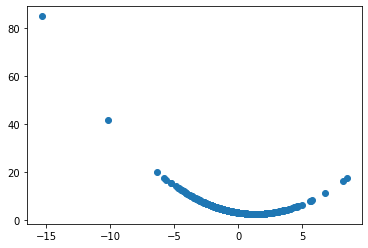

In [43]:
fig, ax = plt.subplots()
ax.scatter(data["return_1"], sm.OLS(u_sq, X, missing = "drop").fit().fittedvalues)

In [44]:
i, j = sorted(enumerate(sm.OLS(u_sq, X, missing = "drop").fit().fittedvalues), key = lambda t: t[1])[0]
print("Return_1:", data["return_1"].iloc[i], "Conditional variance:", j)

Return_1: 1.3219839 Conditional variance: 2.732132332966832


In [45]:
model = sm.OLS(nyse["return"], sm.add_constant(nyse["return_1"]), missing = "drop").fit()
nyse["u_t_sq"] = model.resid ** 2
nyse["u_t1_sq"] = nyse["u_t_sq"].shift(1)
nyse["u_t2_sq"] = nyse["u_t_sq"].shift(2)

sm.OLS(nyse["u_t_sq"], sm.add_constant(nyse[["u_t1_sq", "u_t2_sq"]]), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 u_t_sq   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     44.47
Date:                Tue, 18 May 2021   Prob (F-statistic):           6.96e-19
Time:                        21:59:15   Log-Likelihood:                -2605.8
No. Observations:                 687   AIC:                             5218.
Df Residuals:                     684   BIC:                             5231.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8295      0.455      6.219      0.000       1.936       3.723
u_t1_sq        0.3228      0.038      8.450      0.000       0.248       0.398
u_t2_sq        0.0418      0.038      1.094      0.274      -0.033       0.117
==============================================================================
Omnibus:                     1345.744   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2208061.806
Skew:                          13.888   Prob(JB):                         0.00
Kurtosis:                     279.344   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C11.i Results above but min = 0.0000074, max = 232.89, average = 4.44

C11.ii Results above.

C11.iii Plot above. Smallest value of 2.73 falls at $return_{t-1} = 1.32$.

C11.iv The model does not produce any negative values (not explicitly tested but all values on the plot are greater than 0)

C11.v Example 12.9 does not report an adjusted $R^2$ but the adjusted $R^2$ the model in (ii) 0.128. Given that the adjusted $R^2$ would penalize the inclusion of additional variables, it seems reasonable to say that the model in (ii) is a better fit.

C11.vi The coefficient for the second lag is small with a p-value of 0.274. The adjusted $R^2$ is 0.112 and so the model in (ii) is a better fit.

In [46]:
# Exercise 12
inven = pd.read_stata("stata/INVEN.DTA")
X = sm.add_constant(inven.cgdp)
model = sm.OLS(inven.cinven, X, missing = "drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cinven   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     42.16
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.99e-07
Time:                        21:59:15   Log-Likelihood:                -141.72
No. Observations:                  36   AIC:                             287.4
Df Residuals:                      34   BIC:                             290.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5888      3.641      0.711      0.482      -4.810       9.988
cgdp           0.1525      0.023      6.493      0.000       0.105       0.200
==============================================================================
Omnibus:                        4.258   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                2.922
Skew:                          -0.489   Prob(JB):                        0.232
Kurtosis:                       3.996   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):             -0.017
Method:                 Least Squares   F-statistic:                             0.4076
Date:                Tue, 18 May 2021   Prob (F-statistic):                       0.527
Time:                        21:59:15   Log-Likelihood:                         -138.07
No. Observations:                  35   AIC:                                      278.1
Df Residuals:                      34   BIC:                                      279.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1099      0.172     -0.638      0.527      -0.460       0.240
==============================================================================
Omnibus:                        4.346   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                2.921
Skew:                          -0.539   Prob(JB):                        0.232
Kurtosis:                       3.916   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
FGLS_AR1(model, pw = True).summary()

ρ =  -0.10994573765577026
ρ =  -0.10994579006216582


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.837
Model:                            OLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                              87.32
Date:                Tue, 18 May 2021   Prob (F-statistic):                    4.03e-14
Time:                        21:59:15   Log-Likelihood:                         -141.51
No. Observations:                  36   AIC:                                      287.0
Df Residuals:                      34   BIC:                                      290.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5839      3.448      0.749      0.459      -4.423       9.591
x2             0.1523      0.023      6.685      0.000       0.106       0.199
==============================================================================
Omnibus:                        4.772   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                3.394
Skew:                          -0.549   Prob(JB):                        0.183
Kurtosis:                       4.028   Cond. No.                         273.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C12.i The estimated $\rho$ is -0.11 with a p-value of 0.53. Serial correlation should not be a problem.

C12.ii The estimates are very similar. We should expect them to be since we have no reason to believe that there is serial correlation to correct.

In [49]:
# Exercise 13
okun = pd.read_stata("stata/okun.dta")
X = sm.add_constant(okun[["cunem"]])
model = sm.OLS(okun.pcrgdp, X, missing = "drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pcrgdp   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     107.9
Date:                Tue, 18 May 2021   Prob (F-statistic):           2.04e-13
Time:                        21:59:16   Log-Likelihood:                -68.769
No. Observations:                  46   AIC:                             141.5
Df Residuals:                      44   BIC:                             145.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3444      0.163     20.559      0.000       3.017       3.672
cunem         -1.8909      0.182    -10.388      0.000      -2.258      -1.524
==============================================================================
Omnibus:                        0.827   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.661   Jarque-Bera (JB):                0.791
Skew:                           0.033   Prob(JB):                        0.674
Kurtosis:                       2.361   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
okun["u_t"] = model.resid
okun["u_t1"] = okun["u_t"].shift(1)

sm.OLS(okun.u_t, sm.add_constant(okun[["cunem", "u_t1"]]), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                   0.08914
Date:                Tue, 18 May 2021   Prob (F-statistic):              0.915
Time:                        21:59:16   Log-Likelihood:                -67.365
No. Observations:                  45   AIC:                             140.7
Df Residuals:                      42   BIC:                             146.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0177      0.167      0.106      0.916      -0.319       0.354
cunem          0.0395      0.207      0.191      0.849      -0.378       0.457
u_t1           0.0729      0.173      0.422      0.675      -0.275       0.421
==============================================================================
Omnibus:                        0.456   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.594
Skew:                          -0.074   Prob(JB):                        0.743
Kurtosis:                       2.457   Cond. No.                         1.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
sm.OLS(model.resid ** 2, model.model.exog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.271
Date:                Tue, 18 May 2021   Prob (F-statistic):             0.0447
Time:                        21:59:16   Log-Likelihood:                -77.229
No. Observations:                  46   AIC:                             158.5
Df Residuals:                      44   BIC:                             162.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1682      0.196      5.975      0.000       0.774       1.562
x1             0.4521      0.219      2.067      0.045       0.011       0.893
==============================================================================
Omnibus:                       22.486   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.901
Skew:                           1.592   Prob(JB):                     7.17e-08
Kurtosis:                       5.650   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
model.get_robustcov_results(cov_type = "HC3").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pcrgdp   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     51.25
Date:                Tue, 18 May 2021   Prob (F-statistic):           6.69e-09
Time:                        21:59:16   Log-Likelihood:                -68.769
No. Observations:                  46   AIC:                             141.5
Df Residuals:                      44   BIC:                             145.2
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3444      0.170     19.637      0.000       3.001       3.688
cunem         -1.8909      0.264     -7.159      0.000      -2.423      -1.359
==============================================================================
Omnibus:                        0.827   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.661   Jarque-Bera (JB):                0.791
Skew:                           0.033   Prob(JB):                        0.674
Kurtosis:                       2.361   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

C13.i We do not find evidence for serial correlation without assuming strict exogeneity.

C13.ii The coefficient for $cunem$ is positive and significant, suggesting the variance increases as $cunem$ does. This is evidence of heteroskedasticity.

C13.iii The standard error increases from 0.182 to 0.264.

In [53]:
# Exercise 14
minwage = pd.read_stata("stata/minwage.dta")
data = minwage[["gwage232", "gmwage", "gcpi"]].dropna()
X = sm.add_constant(data[["gmwage", "gcpi"]])
model = sm.OLS(data["gwage232"], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gwage232   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     125.8
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.91e-46
Time:                        21:59:16   Log-Likelihood:                 2091.6
No. Observations:                 611   AIC:                            -4177.
Df Residuals:                     608   BIC:                            -4164.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.185      0.000       0.001       0.003
gmwage         0.1506      0.010     15.591      0.000       0.132       0.170
gcpi           0.2435      0.082      2.965      0.003       0.082       0.405
==============================================================================
Omnibus:                       73.109   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.495
Skew:                           0.455   Prob(JB):                     2.79e-67
Kurtosis:                       6.348   Cond. No.                         257.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
sm.OLS(model.resid, model.resid.shift(1), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              5.833
Date:                Tue, 18 May 2021   Prob (F-statistic):                      0.0160
Time:                        21:59:16   Log-Likelihood:                          2090.6
No. Observations:                 610   AIC:                                     -4179.
Df Residuals:                     609   BIC:                                     -4175.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0974      0.040     -2.415      0.016      -0.177      -0.018
==============================================================================
Omnibus:                       79.211   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.017
Skew:                           0.527   Prob(JB):                     3.94e-69
Kurtosis:                       6.359   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
data["u_t"] = model.resid
data["u_t1"] = data["u_t"].shift(1)

sm.OLS(data["u_t"], sm.add_constant(data[["gmwage", "gcpi", "u_t1"]]), missing = "drop").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u_t   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.953
Date:                Tue, 18 May 2021   Prob (F-statistic):              0.120
Time:                        21:59:16   Log-Likelihood:                 2090.6
No. Observations:                 610   AIC:                            -4173.
Df Residuals:                     606   BIC:                            -4156.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.115e-05      0.000     -0.074      0.941      -0.001       0.001
gmwage         0.0020      0.010      0.211      0.833      -0.017       0.021
gcpi           0.0081      0.082      0.099      0.922      -0.153       0.169
u_t1          -0.0983      0.041     -2.420      0.016      -0.178      -0.019
==============================================================================
Omnibus:                       77.245   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.913
Skew:                           0.488   Prob(JB):                     6.23e-72
Kurtosis:                       6.457   Cond. No.                         257.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
sm.OLS(data["gwage232"], X).fit(cov_type = "HAC", cov_kwds = {"maxlags": 12}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gwage232   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     16.72
Date:                Tue, 18 May 2021   Prob (F-statistic):           8.56e-08
Time:                        21:59:16   Log-Likelihood:                 2091.6
No. Observations:                 611   AIC:                            -4177.
Df Residuals:                     608   BIC:                            -4164.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      6.970      0.000       0.002       0.003
gmwage         0.1506      0.045      3.349      0.001       0.062       0.239
gcpi           0.2435      0.063      3.839      0.000       0.119       0.368
==============================================================================
Omnibus:                       73.109   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.495
Skew:                           0.455   Prob(JB):                     2.79e-67
Kurtosis:                       6.348   Cond. No.                         257.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

In [57]:
model.get_robustcov_results(cov_type = "HC3").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gwage232   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     6.485
Date:                Tue, 18 May 2021   Prob (F-statistic):            0.00163
Time:                        21:59:16   Log-Likelihood:                 2091.6
No. Observations:                 611   AIC:                            -4177.
Df Residuals:                     608   BIC:                            -4164.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.224      0.000       0.001       0.003
gmwage         0.1506      0.101      1.487      0.137      -0.048       0.349
gcpi           0.2435      0.097      2.503      0.013       0.052       0.435
==============================================================================
Omnibus:                       73.109   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.495
Skew:                           0.455   Prob(JB):                     2.79e-67
Kurtosis:                       6.348   Cond. No.                         257.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [58]:
sm.OLS(model.resid ** 2, model.model.exog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     233.8
Date:                Tue, 18 May 2021   Prob (F-statistic):           4.94e-76
Time:                        21:59:16   Log-Likelihood:                 4712.1
No. Observations:                 611   AIC:                            -9418.
Df Residuals:                     608   BIC:                            -9405.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.765e-05   5.78e-06      8.244      0.000    3.63e-05     5.9e-05
x1             0.0029      0.000     21.613      0.000       0.003       0.003
x2             0.0008      0.001      0.708      0.479      -0.001       0.003
==============================================================================
Omnibus:                      601.468   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46837.630
Skew:                           4.154   Prob(JB):                         0.00
Kurtosis:                      45.080   Cond. No.                         257.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
for i in range(1, 13):
    data["gmwage_" + str(i)] = data["gmwage"].shift(i)
    
model = sm.OLS(data["gwage232"], sm.add_constant(data[["gcpi", "gmwage", "gmwage_1", "gmwage_2", "gmwage_3", "gmwage_4", "gmwage_5", "gmwage_6", "gmwage_7", "gmwage_8", "gmwage_9", "gmwage_10", "gmwage_11", "gmwage_12"]]), missing = "drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gwage232   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     20.18
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.04e-41
Time:                        21:59:16   Log-Likelihood:                 2069.8
No. Observations:                 599   AIC:                            -4110.
Df Residuals:                     584   BIC:                            -4044.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.901      0.000       0.001       0.003
gcpi           0.2078      0.089      2.345      0.019       0.034       0.382
gmwage         0.1493      0.009     15.742      0.000       0.131       0.168
gmwage_1      -0.0043      0.009     -0.458      0.647      -0.023       0.014
gmwage_2       0.0007      0.009      0.076      0.940      -0.018       0.019
gmwage_3      -0.0188      0.009     -1.981      0.048      -0.037      -0.000
gmwage_4      -0.0063      0.010     -0.656      0.512      -0.025       0.013
gmwage_5      -0.0075      0.010     -0.777      0.438      -0.026       0.011
gmwage_6       0.0015      0.010      0.162      0.872      -0.017       0.020
gmwage_7      -0.0005      0.010     -0.048      0.962      -0.019       0.018
gmwage_8       0.0190      0.010      1.999      0.046       0.000       0.038
gmwage_9       0.0188      0.010      1.970      0.049    5.52e-05       0.037
gmwage_10      0.0120      0.010      1.258      0.209      -0.007       0.031
gmwage_11      0.0157      0.010      1.634      0.103      -0.003       0.034
gmwage_12      0.0179      0.010      1.868      0.062      -0.001       0.037
==============================================================================
Omnibus:                       66.717   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.898
Skew:                           0.366   Prob(JB):                     8.39e-68
Kurtosis:                       6.441   Cond. No.                         280.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
model.f_test("gmwage_1 = gmwage_2 = gmwage_3 = gmwage_4 = gmwage_5 = gmwage_6 = gmwage_7 = gmwage_8 = gmwage_9 = gmwage_10 = gmwage_11 = gmwage_12 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.72372118]]), p=0.058200217875557875, df_denom=584, df_num=12>

In [61]:
model.get_robustcov_results(cov_type = "HC1").f_test("gmwage_1 = gmwage_2 = gmwage_3 = gmwage_4 = gmwage_5 = gmwage_6 = gmwage_7 = gmwage_8 = gmwage_9 = gmwage_10 = gmwage_11 = gmwage_12 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[4.53119236]]), p=5.199556179121382e-07, df_denom=584, df_num=12>

In [62]:
model = sm.OLS(data["gwage232"], sm.add_constant(data[["gcpi", "gmwage", "gmwage_1", "gmwage_2", "gmwage_3", "gmwage_4", "gmwage_5", "gmwage_6", "gmwage_7", "gmwage_8", "gmwage_9", "gmwage_10", "gmwage_11", "gmwage_12"]]), missing = "drop").fit(cov_type = "HAC", cov_kwds = {"maxlags": 12})
model.f_test("gmwage_1 = gmwage_2 = gmwage_3 = gmwage_4 = gmwage_5 = gmwage_6 = gmwage_7 = gmwage_8 = gmwage_9 = gmwage_10 = gmwage_11 = gmwage_12 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[7.99153598]]), p=6.055669520811908e-14, df_denom=584, df_num=12>

In [63]:
model.params[2:].sum()

0.19759898179185895

C14.i Both tests are quite close with negative coefficients that are significant. We should correct for serial correlation.

C14.ii Results above. The Newey-West standard errors are larger than the OLS standard errors (except $gcpi$ which shrinks), but not enough to affect significance.

C14.iii When using HC3 the significance of $gmwage$ goes away (testing with HC1 it does not, but  I have used this correction before). $gcpi$ is still significant. It is difficult to argue for the HC3 errors though since we've already tested for serial correlation.

C14.iv Test is above. F statistic is 233.8 and so we should correct for heteroskedasticity (as well as serial correlation given the previous results).

C14.v The p-value for the joint f-test is 0.058, just above our usual 5% significance level. The heteroskedasticity-robust test is significant at any level we're interested in (to put it another way, the lags become significant).

C14.vi The p-value for the Newey-West approach is even more significant. The 12 lags, when correcting for heteroskedasticity or heteroskedacicity and serial correlation (the latter being what our tests would suggest), are significant.

C14.vii The LRP without lags is 0.151, while the inclusion of the lags produces asn LRP of 0.198. Whether or not this is a large change may be a matter of opinion. Ignoring that our test has suggested the lags should be included, the confidence interval from the Newey-West estimation without lags (the one our tests would suggest we should use) contains 0.198 within the 95% confidence interval, but a wide confidence interval isn't necessarily an indicator of small changes (it is possible to have a wide confidence interval containing an economically meaningful change).

In [64]:
# Exercise 15
X = sm.add_constant(barium[["lchempi", "lgas", "lrtwex", "befile6", "affile6", "afdec6"]])
model = sm.OLS(barium.lchnimp, X).fit(cov_type = "HAC", cov_kwds = {"maxlags": 4})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lchnimp   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     5.961
Date:                Tue, 18 May 2021   Prob (F-statistic):           1.69e-05
Time:                        21:59:17   Log-Likelihood:                -114.79
No. Observations:                 131   AIC:                             243.6
Df Residuals:                     124   BIC:                             263.7
Df Model:                           6                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.8030     25.293     -0.704      0.482     -67.377      31.771
lchempi        3.1172      0.636      4.902      0.000       1.871       4.364
lgas           0.1964      1.141      0.172      0.863      -2.040       2.433
lrtwex         0.9830      0.421      2.333      0.020       0.157       1.809
befile6        0.0596      0.163      0.366      0.714      -0.259       0.378
affile6       -0.0324      0.213     -0.152      0.879      -0.449       0.385
afdec6        -0.5652      0.242     -2.340      0.019      -1.039      -0.092
==============================================================================
Omnibus:                        9.160   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.978
Skew:                          -0.491   Prob(JB):                      0.00681
Kurtosis:                       3.930   Cond. No.                     9.62e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 9.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
model = sm.OLS(barium.lchnimp, X).fit(cov_type = "HAC", cov_kwds = {"maxlags": 12})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lchnimp   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     6.658
Date:                Tue, 18 May 2021   Prob (F-statistic):           3.99e-06
Time:                        21:59:17   Log-Likelihood:                -114.79
No. Observations:                 131   AIC:                             243.6
Df Residuals:                     124   BIC:                             263.7
Df Model:                           6                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.8030     24.372     -0.730      0.465     -65.572      29.966
lchempi        3.1172      0.721      4.322      0.000       1.704       4.531
lgas           0.1964      1.112      0.177      0.860      -1.983       2.375
lrtwex         0.9830      0.381      2.583      0.010       0.237       1.729
befile6        0.0596      0.123      0.484      0.629      -0.182       0.301
affile6       -0.0324      0.167     -0.195      0.846      -0.359       0.294
afdec6        -0.5652      0.189     -2.986      0.003      -0.936      -0.194
==============================================================================
Omnibus:                        9.160   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.978
Skew:                          -0.491   Prob(JB):                      0.00681
Kurtosis:                       3.930   Cond. No.                     9.62e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
[2] The condition number is large, 9.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C15.i If we suspect serial correlation then we know the OLS errors are understating the variation in the sample. We should settle the question of serial correlation first and then use the appropriate errors.

C15.ii The Newey-West standard error for $lchempi$ is 0.636 (similar to the PW), compared to the 0.48 reported in table 12.1. The OLS standard error $afdec6$ is 0.286, compared to the Newey-West 0.242, smaller than both OLS and the PW (0.342).

C15.iii When using 12 lags $lchempi$'s standard error now increases to 0.721 and $afdec6$ is 0.189. In essence, errors move in the same direction, values that increased getting larger, and values that decreased getting smaller.